In [1]:
# default_exp ward_clustering

In [2]:
# export
from multiinstance.utils import *
from multiinstance.distanceApproaches import *
from multiinstance.data.syntheticData import buildDataset,getBag

import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np

import scipy.stats as ss

from tqdm.notebook import tqdm

from numba import set_num_threads

/home/dz/anaconda3/envs/tf/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/dz/anaconda3/envs/tf/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/dz/anaconda3/envs/tf/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/dz/anaconda3/envs/tf/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/dz/anaconda3/envs/tf/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc si

In [3]:
set_num_threads(10)

In [4]:
# export
class WardClustering:
    def __init__(self, dsi):
        self.clusterAssignment = np.zeros((dsi.N, dsi.N))
        self.clusterAssignment[0] = np.arange(dsi.N)
        self.clusterAlphaHats = {i: dsi.alphaHats[i] for i in range(dsi.N)}
        self.ds = dsi
        self.meanAbsErrs = np.zeros(dsi.N)
        self.deltas = np.zeros(dsi.N - 1)
        self.doLogging(0)
        self.log = []
        
    def doLogging(self, c_iter):
#         print("logging ",c_iter)
        absErrs = []
        clusters = np.unique(self.clusterAssignment[c_iter])
#         print(self.clusterAssignment)
        for ci in clusters:
            bags = np.where(self.clusterAssignment[c_iter] == ci)[0]
#             print(bags)
            aHat = self.clusterAlphaHats[ci].mean()
            alphas = self.ds.trueAlphas[bags].flatten()
            # log abs. err for this cluster
            aes = np.abs(alphas - aHat)
            absErrs.append(aes)
        self.meanAbsErrs[c_iter] = np.mean(np.concatenate(absErrs))
#         print("MAE after ",c_iter," merges: ",self.meanAbsErrs)
    
    def cluster(self):
        for c_iter in tqdm(range(1, self.ds.N),desc="clustering iter",total=self.ds.N-1):
            clusters = np.unique(self.clusterAssignment[c_iter - 1])
            Nc = len(clusters)
            deltas = np.ones((Nc, Nc))
            alphaHats_Merged_Clusters = np.zeros((Nc,Nc, 10))
            for i, ci in tqdm(enumerate(clusters), desc="ci", total=Nc, leave=False):
                alphaHat_ci = self.clusterAlphaHats[ci]
                var_ci = np.sum((alphaHat_ci - alphaHat_ci.mean())**2)
                for j, cj in enumerate(set(clusters)):
                    if i != j:
                        alphaHat_cj = self.clusterAlphaHats[cj]
                        var_cj = np.sum((alphaHat_cj - alphaHat_cj.mean())**2)
                        # alpha hats from i or j
                        alphaHats = np.concatenate((alphaHat_ci,
                                                       alphaHat_cj))
                        # Get alphaHat for joint cluster
                        bagIdxs = np.where(np.isin(self.clusterAssignment[c_iter - 1],[ci,cj]))[0]
                        alphaHat_cij = self.getClusterEst(bagIdxs)
                        alphaHats_Merged_Clusters[i,j] = alphaHat_cij
                        var_cij = np.sum((alphaHats - alphaHat_cij.mean())**2)
                        deltas[i,j]= var_cij - var_ci - var_cj
            # find indices of bags to merge
            idx = np.argmin(deltas)
            i,j = int(idx / deltas.shape[0]), idx % deltas.shape[0]
            ci, cj = clusters[i], clusters[j]
#             print(deltas)
            self.log.append((ci,cj))
            # deltas i indexed list of increase in cluster variance caused by the i+1_th merge
            self.deltas[c_iter - 1] = deltas[i,j]
            # set cluster assignment after this merge
            self.clusterAssignment[c_iter] = self.clusterAssignment[c_iter - 1]
            inJ = np.where(self.clusterAssignment[c_iter] == cj)[0]
            self.clusterAssignment[c_iter, inJ] = ci
            # update the alphaHat to that estimated from the newly formed cluster
            self.clusterAlphaHats[ci] = alphaHats_Merged_Clusters[i,j]
            self.doLogging(c_iter)

    def getClusterEst(self,bagIdxs):
        P,U = list(zip(*[self.ds.getBag(b) for b in bagIdxs]))
        p = np.concatenate(P)
        u = np.concatenate(U)
        alphaHats, _ = getEsts(p,u,10)
        return alphaHats

In [5]:
dsi = buildDataset(10,alphaDistr=lambda: np.random.uniform(.01,.5),
                  nP=10,nU=25)

dsi = addTransformScores(dsi)

dsi.alphaHats,dsi.curves = getBagAlphaHats(dsi,numbootstraps=10)

In [6]:
ward = WardClustering(dsi)

In [7]:
ward.cluster()

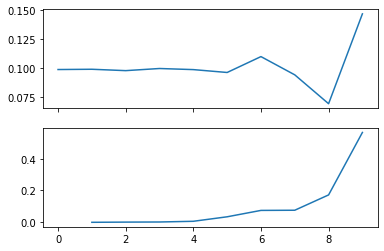

In [8]:
fig, ax= plt.subplots(2,1, sharex=True)
ax[0].plot(ward.meanAbsErrs)
ax[1].plot(np.arange(1, len(ward.deltas) + 1), ward.deltas)

In [10]:
10**3

1000